1. Data Generation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i, N_grid = 5000, 300, 300, 100

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.random.uniform((N_f, 1), w_min, w_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.random.uniform((N_b, 1), w_min, w_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
w_i = tf.random.uniform((N_i, 1), w_min, w_max, dtype=DTYPE)

x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

In [2]:
# check shapes and data types
print(tf.shape(x_is))
print(x_is.dtype)
print(tf.shape(t_is))
print(t_is.dtype)
print(tf.shape(w_is))
print(w_is.dtype)

print(tf.shape(x_bs))
print(x_bs.dtype)
print(tf.shape(t_bs))
print(t_bs.dtype)
print(tf.shape(w_bs))
print(w_bs.dtype)

print(tf.shape(x_fs))
print(x_fs.dtype)
print(tf.shape(t_fs))
print(t_fs.dtype)
print(tf.shape(w_fs))
print(w_fs.dtype)

print(tf.shape(x_ns))
print(x_ns.dtype)

tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([100   1], shape=(2,), dtype=int32)
<dtype: 'float64'>


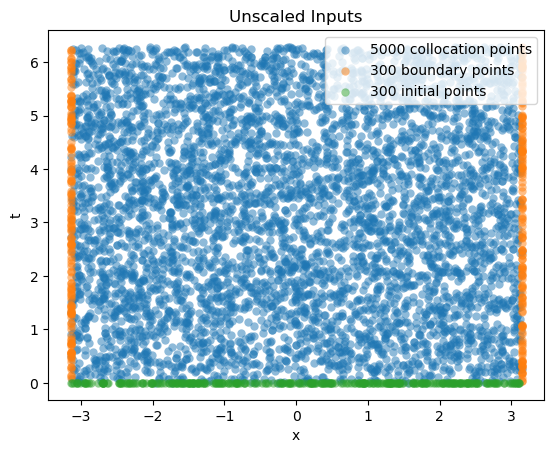

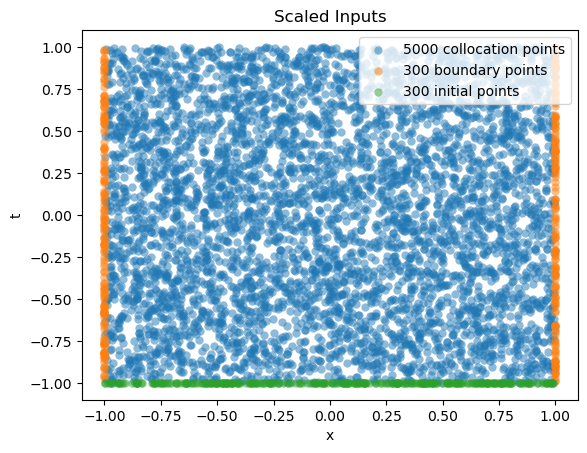

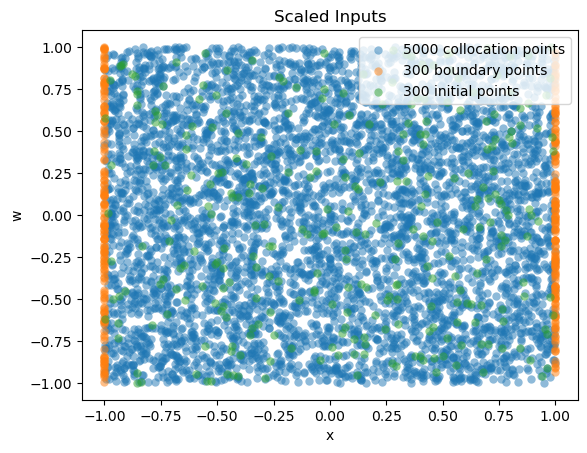

In [2]:
# plot data points

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Unscaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

# plt.scatter(x_f, w_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# plt.scatter(x_b, w_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# plt.scatter(x_i, w_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# plt.xlabel('x')
# plt.ylabel('w')
# plt.title('Unscaled Inputs')
# plt.legend(loc='upper right')
# plt.show()

plt.scatter(x_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

2. Model Architecture

In [2]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense6 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense7 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense8 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

3. Loss function

In [3]:
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, w):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            xs = scale_inputs(x, x_min, x_max)
            ts = scale_inputs(t, t_min, t_max)
            ws = scale_inputs(w, w_min, w_max)
            X = tf.concat([xs, ts, ws], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def norm_loss(model, x_ns, N_t, w_val=1.0):
    w_n = tf.ones_like(x_ns) * w_val
    w_ns = scale_inputs(w_n, w_min, w_max)
    t_n = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    t_ns = scale_inputs(t_n, t_min, t_max)
    norm_penalty_total = 0.0
    for t_val in tf.unstack(t_ns, axis=0):
        t_in = tf.ones_like(x_ns) * t_val
        X = tf.concat([x_ns, t_in, w_ns], axis=1)
        uv = model(X)
        dx = (x_max - x_min) / tf.cast(tf.shape(x_ns)[0], dtype=DTYPE)
        norm = tf.reduce_sum(tf.math.abs(uv)**2) * dx
        norm_penalty_total += tf.square(norm - 1.0)
    norm_penalty = norm_penalty_total / tf.cast(N_t, dtype=DTYPE)

    return norm_penalty

@tf.function
def loss_fn(model, interior, boundary, initial, omega, norm_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    w_f, w_b, w_i = omega
    x_grid, N_t, w_val = norm_grid

    f_u, f_v = pde_residual(model, x_f, t_f, w_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b, w_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i, w_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    norm_penalty = norm_loss(model, x_grid, N_t, w_val)
    
    return loss_f + loss_b + loss_i + norm_penalty, (loss_f, loss_b, loss_i, norm_penalty)

In [ ]:
# Create the model
model = PINN(input_dim=3, mapping_size=512, scale=10.0)

# Save the model in Keras format
model_test_path = 'model_test_v5.keras'
model.save(model_test_path)
print(f"Model saved to {model_test_path}")

# Load the model
loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# Dummy input to build the model (batch size 1, input_dim = 2)
dummy_input = tf.concat([x_f[:5], t_f[:5], w_f[:5]], axis=1)
_ = loaded_model(dummy_input)

loaded_model.summary()

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model saved to model_test_v3.keras


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_1         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (5, 512)               │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (5, 2)                 │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,365,954 (18.05 MB)

 Trainable params: 2,364,418 (18.04 MB)

 Non-trainable params: 1,536 (12.00 KB)

4. Learning rate and Train step function

In [4]:
# Define the Optimizer
# Learning rate schedule with exponential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# ADAM optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, w_f, w_b, w_i, x_n, N_t, w_val):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, ln) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (w_f, w_b, w_i), (x_n, N_t, w_val))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, ln)

5. Training Loop

Epoch 0: Loss = 6.71860e+01 (f = 6.606e+01, b = 2.289e-01, i = 4.034e-01, n = 4.972e-01)


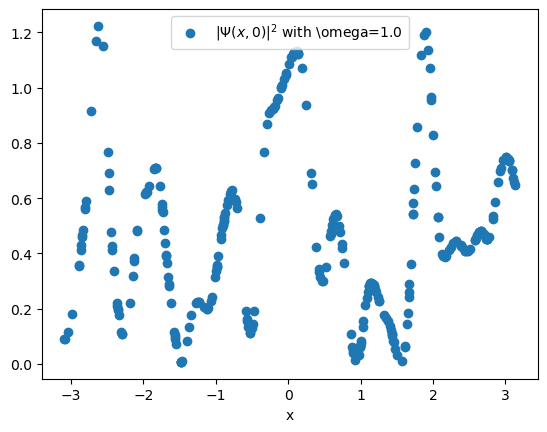

Best model saved to best_model_s4v0.keras at epoch 0 with loss 67.1859840975779
Best model saved to best_model_s4v0.keras at epoch 3 with loss 26.02138809310012
Best model saved to best_model_s4v0.keras at epoch 4 with loss 18.159319195391827
Best model saved to best_model_s4v0.keras at epoch 5 with loss 12.23631372163516
Best model saved to best_model_s4v0.keras at epoch 6 with loss 7.852583954788022
Best model saved to best_model_s4v0.keras at epoch 7 with loss 6.507646939590878
Best model saved to best_model_s4v0.keras at epoch 8 with loss 4.552065093204987
Best model saved to best_model_s4v0.keras at epoch 9 with loss 3.504153843866934
Best model saved to best_model_s4v0.keras at epoch 10 with loss 3.266191658407181
Best model saved to best_model_s4v0.keras at epoch 11 with loss 2.5108134800927724
Best model saved to best_model_s4v0.keras at epoch 12 with loss 2.362827967858961
Best model saved to best_model_s4v0.keras at epoch 13 with loss 2.0110115646148112
Best model saved to be

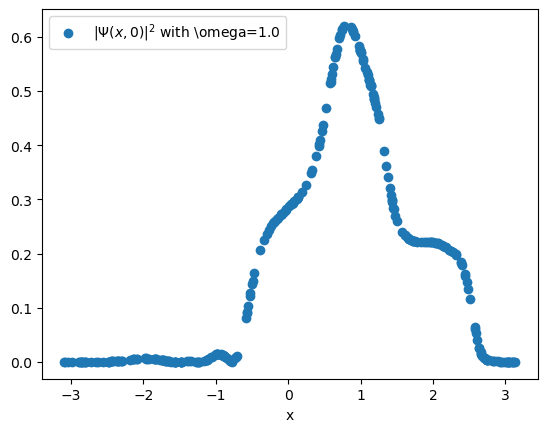

Best model saved to best_model_s4v0.keras at epoch 505 with loss 0.002846868530031084
Best model saved to best_model_s4v0.keras at epoch 507 with loss 0.002670115181192402
Best model saved to best_model_s4v0.keras at epoch 548 with loss 0.0025136571579840354
Best model saved to best_model_s4v0.keras at epoch 549 with loss 0.00245553541451422
Best model saved to best_model_s4v0.keras at epoch 550 with loss 0.002178355248057353
Best model saved to best_model_s4v0.keras at epoch 551 with loss 0.0017765940573092071
Best model saved to best_model_s4v0.keras at epoch 554 with loss 0.001721254200289792
Best model saved to best_model_s4v0.keras at epoch 555 with loss 0.0015648067632853522
Best model saved to best_model_s4v0.keras at epoch 556 with loss 0.0014881743997122374
Best model saved to best_model_s4v0.keras at epoch 557 with loss 0.0014325615608495902
Best model saved to best_model_s4v0.keras at epoch 558 with loss 0.0012193942316734362
Best model saved to best_model_s4v0.keras at epoc

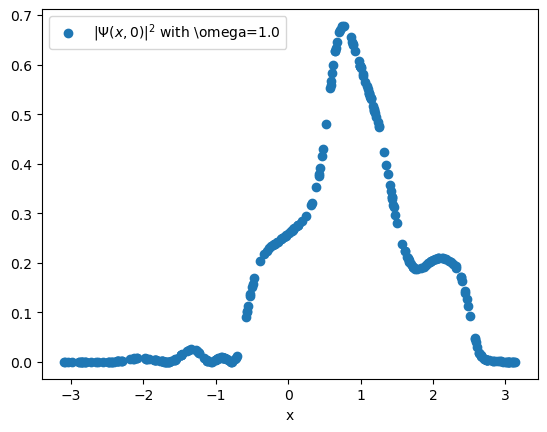

Best model saved to best_model_s4v0.keras at epoch 1016 with loss 0.00024110903943814373
Best model saved to best_model_s4v0.keras at epoch 1017 with loss 0.00022629426314717136
Best model saved to best_model_s4v0.keras at epoch 1020 with loss 0.00022410954788091498
Best model saved to best_model_s4v0.keras at epoch 1022 with loss 0.00021225727292798854
Best model saved to best_model_s4v0.keras at epoch 1024 with loss 0.0001669509958715899
Best model saved to best_model_s4v0.keras at epoch 1025 with loss 0.00016258159886987954
Best model saved to best_model_s4v0.keras at epoch 1026 with loss 0.00015778707004452294
Best model saved to best_model_s4v0.keras at epoch 1027 with loss 0.00014855936055101264
Best model saved to best_model_s4v0.keras at epoch 1029 with loss 0.0001353515582187731
Best model saved to best_model_s4v0.keras at epoch 1031 with loss 0.00012140147611563322
Best model saved to best_model_s4v0.keras at epoch 1032 with loss 0.00011971646126433977
Best model saved to bes

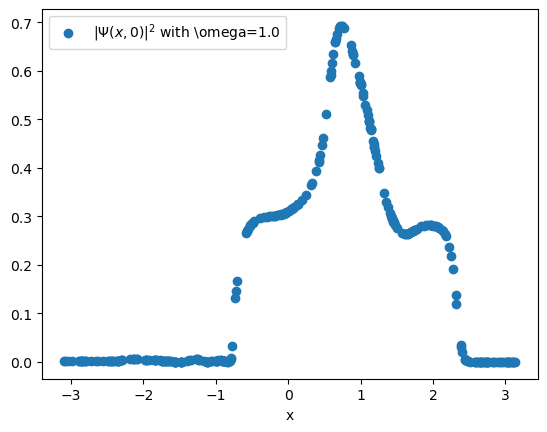

Epoch 2000: Loss = 1.65141e-04 (f = 1.118e-04, b = 5.819e-06, i = 4.569e-05, n = 1.886e-06)


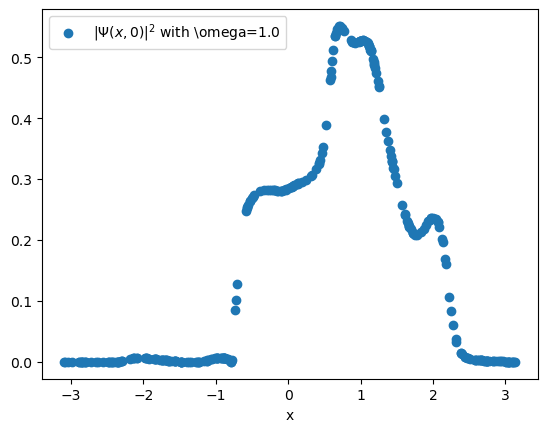

Best model saved to best_model_s4v0.keras at epoch 2131 with loss 8.618136650607228e-05
Best model saved to best_model_s4v0.keras at epoch 2140 with loss 7.978933277001626e-05
Best model saved to best_model_s4v0.keras at epoch 2141 with loss 7.6453321022778e-05
Best model saved to best_model_s4v0.keras at epoch 2143 with loss 7.64031904294117e-05
Best model saved to best_model_s4v0.keras at epoch 2144 with loss 6.873774628835918e-05
Best model saved to best_model_s4v0.keras at epoch 2150 with loss 6.824505888816947e-05
Best model saved to best_model_s4v0.keras at epoch 2195 with loss 6.790040439748205e-05
Best model saved to best_model_s4v0.keras at epoch 2196 with loss 6.712799028661602e-05
Best model saved to best_model_s4v0.keras at epoch 2197 with loss 6.472331199829871e-05
Best model saved to best_model_s4v0.keras at epoch 2198 with loss 6.401202996735497e-05
Best model saved to best_model_s4v0.keras at epoch 2199 with loss 6.233397967315223e-05
Best model saved to best_model_s4v0

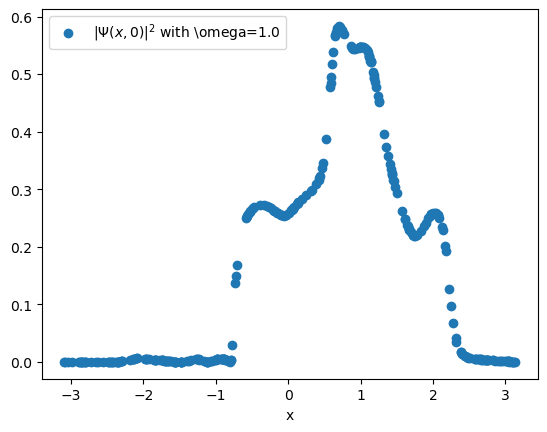

Best model saved to best_model_s4v0.keras at epoch 2593 with loss 5.546617252274868e-05
Best model saved to best_model_s4v0.keras at epoch 2594 with loss 5.273025723973145e-05
Best model saved to best_model_s4v0.keras at epoch 2596 with loss 5.040581197155165e-05
Best model saved to best_model_s4v0.keras at epoch 2598 with loss 5.0356643530572096e-05
Best model saved to best_model_s4v0.keras at epoch 2599 with loss 4.224408752031803e-05
Best model saved to best_model_s4v0.keras at epoch 2601 with loss 4.099842815120838e-05
Best model saved to best_model_s4v0.keras at epoch 2603 with loss 4.062685701236444e-05
Best model saved to best_model_s4v0.keras at epoch 2605 with loss 3.8330642802739694e-05
Best model saved to best_model_s4v0.keras at epoch 2609 with loss 3.513332099514086e-05
Epoch 3000: Loss = 1.94580e-03 (f = 1.481e-03, b = 3.367e-05, i = 2.613e-04, n = 1.700e-04)


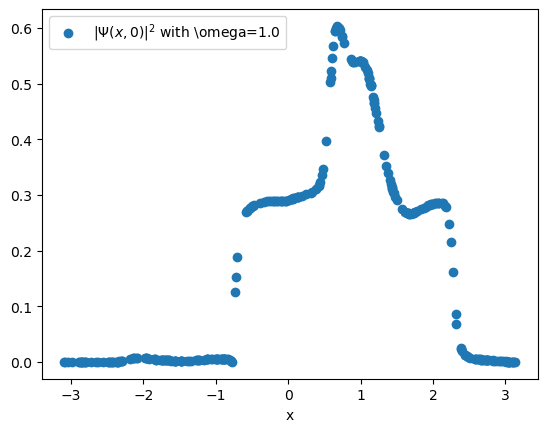

Best model saved to best_model_s4v0.keras at epoch 3226 with loss 3.322230477576882e-05
Best model saved to best_model_s4v0.keras at epoch 3242 with loss 2.8756492375197696e-05
Best model saved to best_model_s4v0.keras at epoch 3245 with loss 2.7120013312470258e-05
Best model saved to best_model_s4v0.keras at epoch 3417 with loss 2.652219723839799e-05
Best model saved to best_model_s4v0.keras at epoch 3424 with loss 2.567858610348497e-05
Best model saved to best_model_s4v0.keras at epoch 3434 with loss 2.2963856435303532e-05
Best model saved to best_model_s4v0.keras at epoch 3439 with loss 2.2006560674005225e-05
Best model saved to best_model_s4v0.keras at epoch 3441 with loss 2.1907776866986816e-05
Best model saved to best_model_s4v0.keras at epoch 3444 with loss 2.0780736799032313e-05
Best model saved to best_model_s4v0.keras at epoch 3446 with loss 2.0592143419872517e-05
Best model saved to best_model_s4v0.keras at epoch 3449 with loss 1.8825893486054627e-05
Epoch 3500: Loss = 1.127

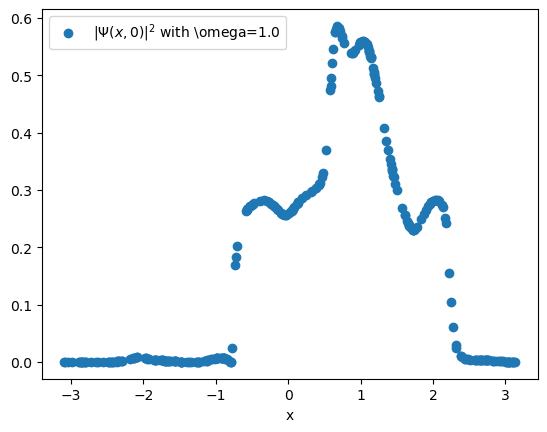

Epoch 4000: Loss = 2.73574e-04 (f = 1.875e-04, b = 4.641e-06, i = 9.046e-06, n = 7.239e-05)


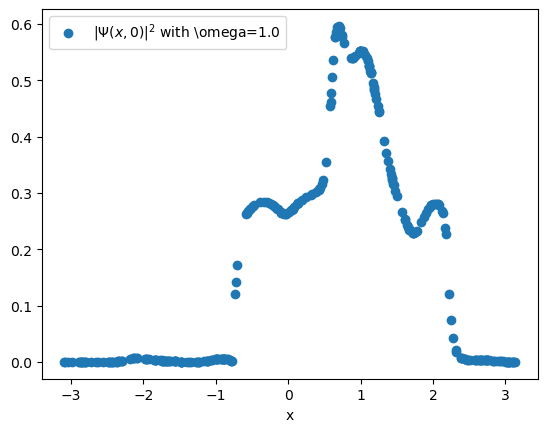

Epoch 4500: Loss = 1.11405e-04 (f = 9.118e-05, b = 2.362e-06, i = 1.246e-05, n = 5.407e-06)


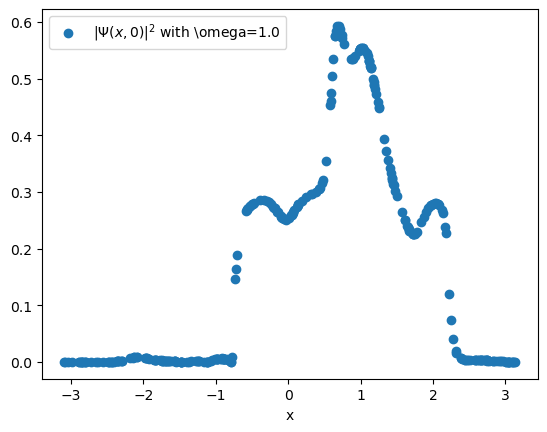

Best model saved to best_model_s4v0.keras at epoch 4594 with loss 1.803459837694598e-05
Epoch 5000: Loss = 4.76603e-01 (f = 2.418e-01, b = 7.854e-03, i = 8.379e-02, n = 1.432e-01)


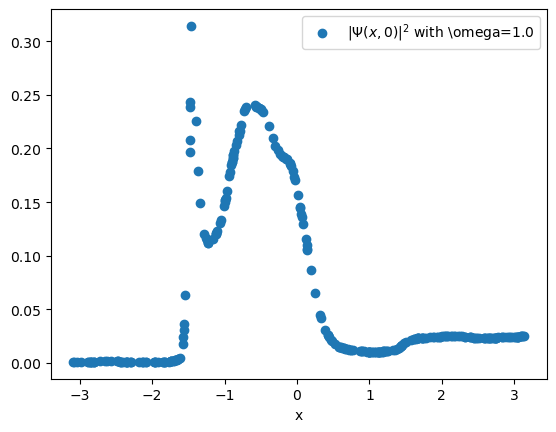

Epoch 5500: Loss = 2.37127e-02 (f = 6.898e-03, b = 5.013e-04, i = 1.030e-02, n = 6.011e-03)


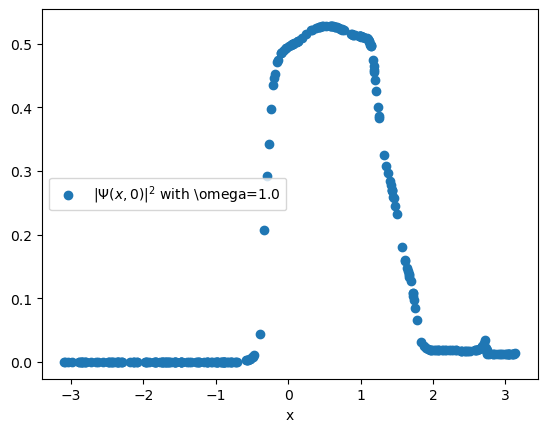

Epoch 6000: Loss = 2.40545e-02 (f = 1.338e-02, b = 8.102e-04, i = 8.932e-03, n = 9.293e-04)


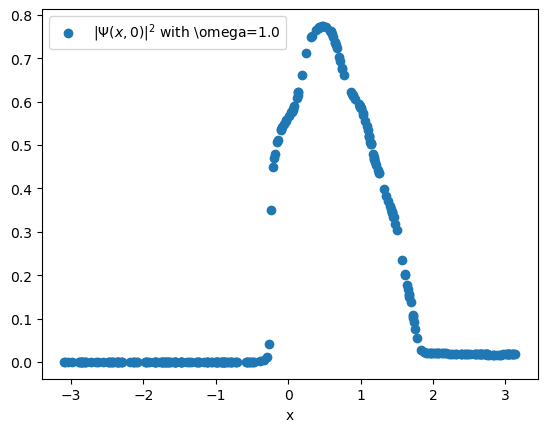

Epoch 6500: Loss = 2.17800e-02 (f = 1.265e-02, b = 6.878e-04, i = 7.045e-03, n = 1.395e-03)


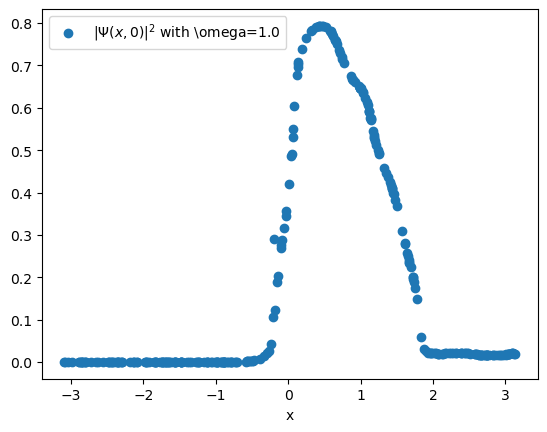

Early stopping at epoch 6594 as loss did not improve for 2000 epochs.
Training stopped at epoch 6594 with loss 0.01869299754882597
Total training time: 13:38:12


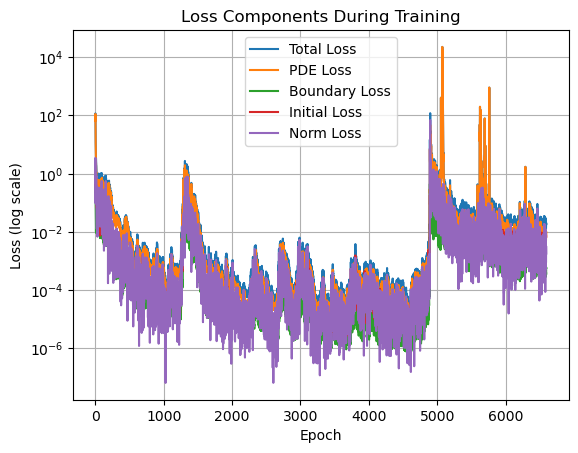


Weights match.
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!


In [5]:
# Instantiate the Model
pinn = PINN(input_dim=3, mapping_size=512, scale=10.0)

# pinn = tf.keras.models.load_model('best_model_s4v0.keras', custom_objects={'PINN': PINN})
# print("Model loaded successfully")

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 2000
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm" : []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_s4v0.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, ln) = train_step(pinn, x_f, t_f, x_bs, t_bs, x_is, t_is, psi_i, w_f, w_bs, w_is, x_ns, 3, 1.0)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm"].append(ln.numpy())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}, n = {ln.numpy().item():.3e})")

        w_test = tf.ones_like(x_is)
        w_test_s = scale_inputs(w_test, w_min, w_max)
        X = tf.concat([x_is, t_is, w_test_s], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        # test_Re, test_Im = normalization(x_min, x_max, N_i, u, v)
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$ with \omega=1.0')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch} with loss {loss.numpy()}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm"], label="Norm Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

In [6]:
import csv

# Save to CSV
with open("train_loss_results_s4v0.csv", "w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["epoch", "total_loss", "pde_loss", "boundary_loss", "initial_loss", "norm_loss"])
    
    # Write data row by row
    for epoch, (total, pde, boundary, initial, norm) in enumerate(zip(
        train_loss_results["total"],
        train_loss_results["pde"],
        train_loss_results["boundary"],
        train_loss_results["initial"],
        train_loss_results["norm"]
    )):
        writer.writerow([epoch, total, pde, boundary, initial, norm])


In [7]:
import pandas as pd

df = pd.read_csv("train_loss_results_s4v0.csv")
print(df.head())
print(df.tail())

   epoch  total_loss    pde_loss  boundary_loss  initial_loss  norm_loss
0      0   67.185984   66.056450       0.228903      0.403406   0.497226
1      1  116.960255  112.390348       0.434565      0.662449   3.472894
2      2   87.729807   86.423477       0.243887      0.466097   0.596347
3      3   26.021388   25.571185       0.088502      0.266090   0.095611
4      4   18.159319   17.450682       0.057641      0.217687   0.433309
      epoch  total_loss  pde_loss  boundary_loss  initial_loss  norm_loss
6590   6590    0.012818  0.004995       0.000357      0.006603   0.000863
6591   6591    0.016967  0.007378       0.000406      0.008225   0.000958
6592   6592    0.017668  0.005970       0.000340      0.008106   0.003252
6593   6593    0.020406  0.010251       0.000610      0.007067   0.002478
6594   6594    0.018693  0.009501       0.000576      0.006815   0.001802


6. Loading the Model

Normalization check for the initial condition: $|\Psi(x,0)|**2=1.0372221633918632$
Model loaded successfully


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_2         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (5000, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (5000, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,365,954 (18.05 MB)

 Trainable params: 2,364,418 (18.04 MB)

 Non-trainable params: 1,536 (12.00 KB)

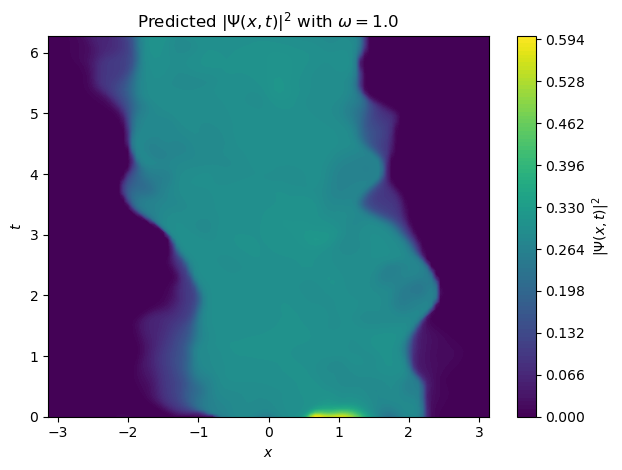

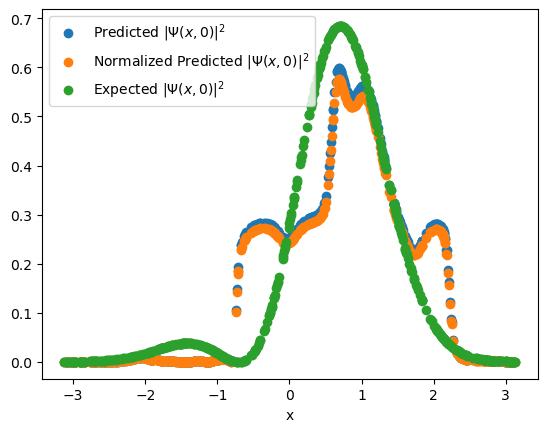

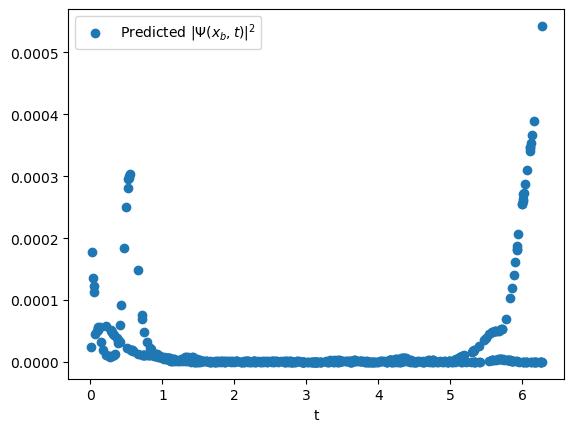

In [8]:
############################## Loading the model ##############################

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / N
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500
w_test = 1.0

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.ones_like(x_f) * w_test
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.ones_like(x_b) * w_test
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)

w_i = tf.ones_like(x_i) * w_test
psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)
# psi_i_Re, psi_i_Im = normalization(x_min, x_max, N_i, tf.math.real(psi_i), tf.math.imag(psi_i))
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

# verify normalization
dx_i = (x_max - x_min) / N_i
norm_check = tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense6 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense7 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense8 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Load the model
loaded_model = tf.keras.models.load_model('best_model_s4v0.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

################## Plot: Contour Plot ###############################

# Contour Plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)
w_plot = tf.ones_like(x_plot_in) * w_test
w_plot_in = scale_inputs(w_plot, w_min, w_max)

density_interior = []

count = 0
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in, w_plot_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2
    # psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
    # density = psi_Re**2 + psi_Im**2
    density_interior.append(density)

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_test}$')
plt.tight_layout()
plt.show()

################## Plot: Initial Condition ###############################

X = tf.concat([x_is, t_is, w_is], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_i, u, v)
density_initial = psi_Re**2 + psi_Im**2

plt.scatter(x_i, u**2 + v**2, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_initial, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, tf.math.abs(psi_i)**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

################## Plot: Boundary Condition ###############################

X = tf.concat([x_bs, t_bs, w_bs], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
density_boundary = psi_Re**2 + psi_Im**2

plt.scatter(t_b, u**2 + v**2, label=r'Predicted $|\Psi(x_b,t)|^2$')
# plt.scatter(t_b, density_boundary, label=r'Normalized Predicted $|\Psi(x_b,t)|^2$')
plt.xlabel('t')
plt.legend()
plt.show()

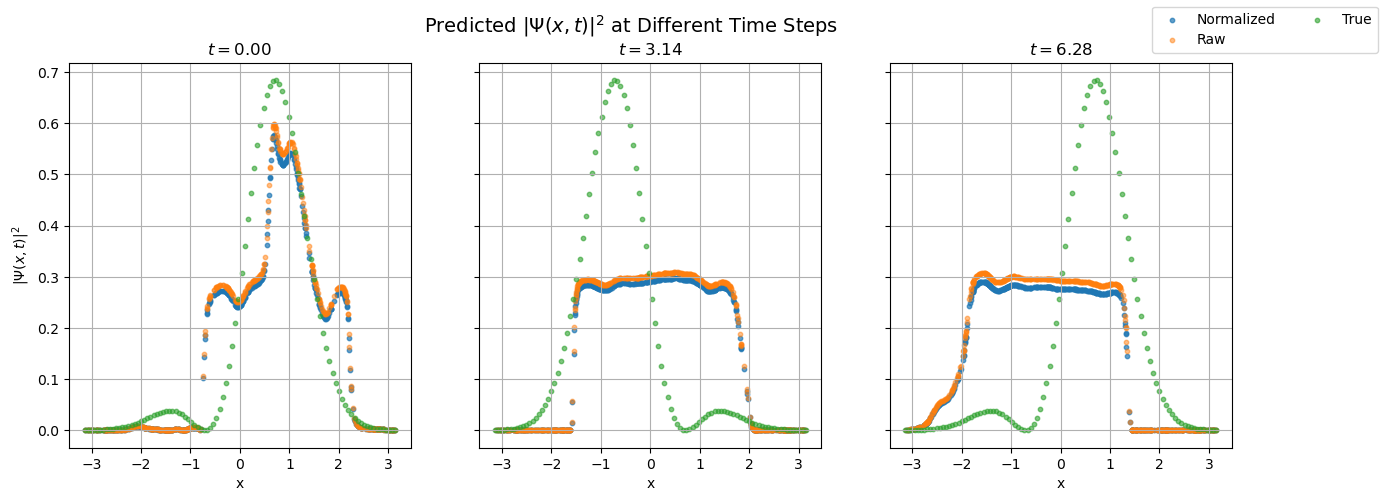

In [9]:
x_true = np.linspace(x_min, x_max, 100)

# Compute theoretical |Psi(x,t)|^2 as before
def U_0(x, t):
    w = 1.0
    return np.exp(-1j * 0.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0)

def U_1(x, t):
    w = 1.0
    return np.exp(-1j * 1.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0) * x * np.sqrt(2.0*w)

# Define time steps
t_test = [0, np.pi, 2.0*np.pi]

# Create subplots
fig, axs = plt.subplots(1, len(t_test), figsize=(15, 5), sharey=True)

for i, t_val in enumerate(t_test):
    t_in = tf.ones_like(x_is) * t_val
    t_ins = scale_inputs(t_in, t_min, t_max)
    X = tf.concat([x_is, t_ins, w_bs], axis=1)
    uv = loaded_model(X)
    u, v = uv[:, 0:1], uv[:, 1:2]
    psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
    density = psi_Re**2 + psi_Im**2

    t_true = np.ones_like(x_true) * t_val
    psi_true = (1.0 / np.sqrt(2.0)) * (U_0(x_true, t_true) + U_1(x_true, t_true))
    density_true = np.abs(psi_true)**2

    ax = axs[i]
    ax.scatter(x_i, density, s=10, label="Normalized", alpha=0.7)
    ax.scatter(x_i, u**2 + v**2, s=10, label="Raw", alpha=0.5)
    ax.scatter(x_true, density_true, s=10, label="True", alpha=0.6)
    ax.set_title(f"$t = {t_val:.2f}$")
    ax.set_xlabel("x")
    if i == 0:
        ax.set_ylabel(r"$|\Psi(x,t)|^2$")
    ax.grid(True)

# Add a single legend and adjust layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2)
fig.suptitle("Predicted $|\Psi(x,t)|^2$ at Different Time Steps", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Text(0.5, 1.0, 'Max Amplitude over Time')

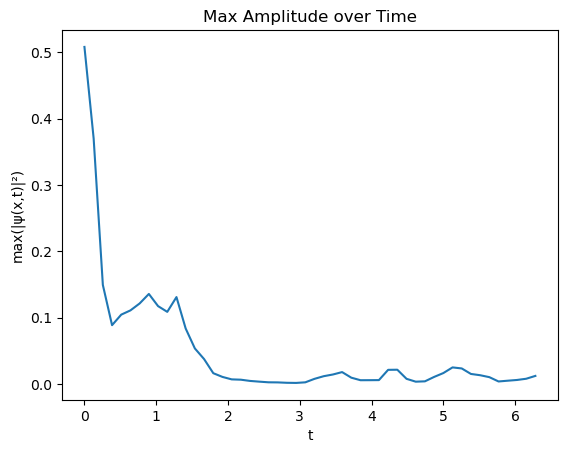

In [11]:
max_amplitudes = []
t_eval = np.linspace(t_min, t_max, 50)
for t_val in t_eval:  # t_eval = list of times like [0, pi, 2pi]
    x_grid = np.linspace(x_min, x_max, 300).reshape(-1, 1)
    t_grid = np.full_like(x_grid, t_val)
    inputs = tf.concat([
        scale_inputs(x_grid, x_min, x_max),
        scale_inputs(t_grid, t_min, t_max),
        tf.ones_like(x_grid)  # Assuming w=0 for plotting or same value
    ], axis=1)
    pred = loaded_model(inputs)
    psi = pred[:, 0]**2 + pred[:, 1]**2
    max_amplitudes.append(tf.reduce_max(psi).numpy())

plt.plot(t_eval, max_amplitudes)
plt.xlabel("t")
plt.ylabel("max(|ψ(x,t)|²)")
plt.title("Max Amplitude over Time")

Text(0.5, 1.0, 'PDE Residual Heatmap')

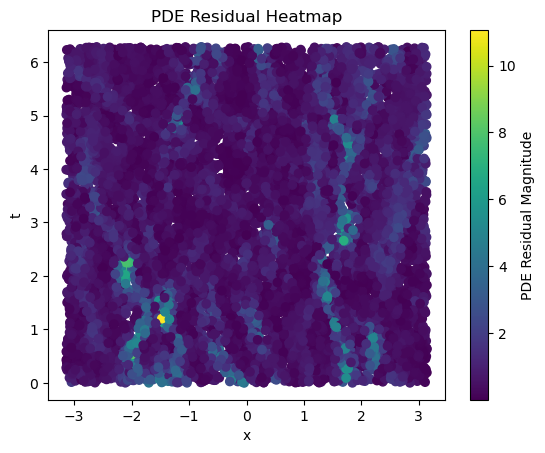

In [12]:
w_val = tf.ones_like(x_f)
f_u, f_v = pde_residual(loaded_model, x_f, t_f, w_val)
residual = tf.abs(f_u) + tf.abs(f_v)

# Optional: reshape to 2D grid if you're visualizing over mesh
plt.scatter(x_f.numpy(), t_f.numpy(), c=residual.numpy(), cmap="viridis")
plt.colorbar(label="PDE Residual Magnitude")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PDE Residual Heatmap")